In [46]:
import numpy as np
from scipy.special import gamma
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

In [47]:
# Original solver
def equilibrium(T_c, T_k, t_ck, theta, rho, alpha, eta):
    # Inital values
    w_ck = np.ones((10,5))
    P_yk = np.ones(5)
    Y_c = np.ones(10)

    # Calculate the initial values
    P = np.sum(P_yk)
    Y = np.sum(Y_c)
    lambda_k = np.sum(t_ck * w_ck, axis=0)
    Gamma = gamma((theta - 1) / theta)

    # Initialize variables
    epsilon = 1e-6
    Y = np.sum(Y_c)
    Y_prev = Y + 2 * epsilon  # Ensure the loop starts
    Y_values = []  # List to store Y values for each iteration

    while abs(Y - Y_prev) >= epsilon: # The truth condition checks for convergence
        # Use previous Y value to calculate w_ck
        Y_prev = Y
        P = np.sum(P_yk)
        Y = np.sum(Y_c)
        lambda_k = np.sum(t_ck * w_ck, axis=0)

        # Top and bottom of the second term in equation 11
        top = P_yk ** (alpha - eta)
        bottom = lambda_k ** (- rho)

        # Left is the first term, middle second and right third of equation 11
        left = (np.outer(T_c, T_k) ** (alpha - 1)) / t_ck
        middle = top / bottom
        middle = np.tile(middle, (10, 1))
        right = (P ** eta) * Y / Gamma

        # Calculate the new values
        w_ck = (left * middle * right) ** (1 / (theta + alpha - 1))
        z_ck = Gamma * t_ck * (w_ck ** (theta - 1)) * (lambda_k ** (- rho))
        Q_ck = np.outer(T_c, T_k) * z_ck
        P_yk = np.mean(w_ck / np.outer(T_c, T_k), axis=0)
        Y = np.sum(Q_ck)
        
        Y_values.append(Y)  # Append the current value of Y to the list

    # Calculate pi_ck and pi_c
    pi_ck_left = t_ck * (w_ck ** theta)
    pi_ck_right = (lambda_k ** (- rho)) / np.sum(lambda_k ** (1 - rho))
    pi_ck = pi_ck_left * pi_ck_right

    pi_c_left = (t_ck * (w_ck ** theta)) / np.sum(t_ck * (w_ck ** theta), axis=0)
    pi_c_right = (lambda_k ** (1 - rho)) / np.sum(lambda_k ** (1 - rho))
    pi_c = np.sum(pi_c_left * pi_c_right, axis=1)

    return w_ck, P_yk, Q_ck, pi_ck, pi_c

def solve_equilibrium(T_c, T_k, t_ck, theta, rho, alpha, eta):
    # Set the initial values and flatten for solver
    w_ck = np.ones((10,5)).flatten()

    def objective(w_ck):
        # Reshape the input to the correct shape
        w_ck = w_ck.reshape((10, 5))
        # Define Q and Y
        # Q = np.outer(T_c, T_k) * gamma((theta - 1) / theta) * t_ck * w_ck ** (theta - 1) * np.sum(t_ck * w_ck ** theta, axis=0) ** (-rho)
        # Q = np.sum(Q)
        # Y = np.sum(gamma((theta - 1) / theta) * t_ck * w_ck ** theta * np.sum(t_ck * w_ck ** theta, axis=0) ** (-rho), axis=1) / np.sum(w_ck / np.outer(T_c, T_k), axis=1)
        # Y = np.sum(Y)

        lhs_first = (w_ck / np.outer(T_c, T_k)) ** (- alpha)
        lhs_second = np.sum((w_ck / np.outer(T_c, T_k)) ** (1 - alpha), axis=0) ** ((alpha - eta) / (1 - alpha))
        lhs_third = np.sum(np.sum((w_ck / np.outer(T_c, T_k)) ** (1 - alpha), axis=0) ** ((1 - eta) / (1 - alpha)), axis=0) ** ((eta - 1) / (1 - eta))
        lhs_fourth = np.sum(w_ck)
        lhs = lhs_first * lhs_second * lhs_third * lhs_fourth
        lhs = np.sum(lhs)

        rhs = gamma((1 - theta) / theta) * np.outer(T_c, T_k) * (w_ck ** (theta - 1)) * (np.sum(w_ck ** theta, axis=0) ** (-rho)) * (np.sum(np.sum(w_ck, axis=0) ** (1 - rho), axis=0) ** ((1 - theta) / theta))
        rhs = np.sum(rhs)

        # Return the objective function which is the difference between Q and Y
        return (lhs - rhs) ** 2

    # Minimize the objective function
    w_ck = minimize(objective, w_ck, method='BFGS').x.reshape((10, 5))

    # Calculate the rest of the equilibrium
    lambda_k = np.sum(t_ck * w_ck, axis=0)
    pi_ck_left = t_ck * (w_ck ** theta)
    pi_ck_right = (lambda_k ** (- rho)) / np.sum(lambda_k ** (1 - rho))
    pi_ck = pi_ck_left * pi_ck_right

    pi_c_left = (t_ck * (w_ck ** theta)) / np.sum(t_ck * (w_ck ** theta), axis=0)
    pi_c_right = (lambda_k ** (1 - rho)) / np.sum(lambda_k ** (1 - rho))
    pi_c = np.sum(pi_c_left * pi_c_right, axis=1)

    return pi_c, pi_ck, w_ck

In [48]:
# Set the random seed
np.random.seed(42)

# Generate random parameters
T_c = np.random.normal(loc=10, scale=3, size=10)
T_k = np.random.normal(loc=10, scale=3, size=5)
t_ck = np.random.normal(loc=10, scale=3, size=(10,5))

similarity_factor = 0.8  # Factor to control similarity (1.0 means identical)

# Make certain cities similar to each other
for i in [1, 3, 8]:
    t_ck[i] = similarity_factor * t_ck[6] + (1 - similarity_factor) * np.random.normal(loc=10, scale=3, size=(5,))

# Assumed parameters
theta = 3
rho = 0.4
alpha = 7
eta = 1.65

# Calculate the equilibrium
w_ck, P_yk, Q_ck, pi_ck, pi_c = equilibrium(T_c, T_k, t_ck, theta, rho, alpha, eta)

# Shock the 7th city
T_c[6] = T_c[6] * 0.85
w_shock_ck, P_shock_yk, Q_shock_ck, pi_shock_ck, pi_shock_c = equilibrium(T_c, T_k, t_ck, theta, rho, alpha, eta)

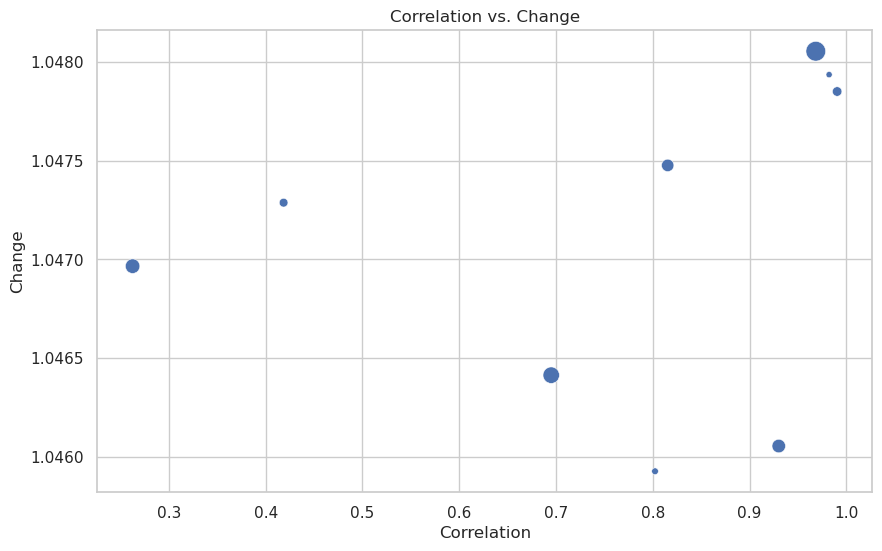

In [49]:
reference_row = t_ck[6]
correlation = []
# for row in t_ck:
#     correlation.append(np.abs(np.corrcoef(reference_row, row)[0,1]))

# Calculate correlation excluding row 6
for i, row in enumerate(t_ck):
    if i != 6:
        correlation.append(np.abs(np.corrcoef(reference_row, row)[0, 1]))

# Calculate change
change = pi_shock_c / pi_c

# Ensure change has the same length as correlation (excluding row 6)
change = np.delete(change, 6)

sizes = np.delete(pi_c, 6)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Assuming correlation and change are already defined
# Plot correlation vs. change using seaborn
sns.scatterplot(x=correlation, y=change, size=sizes, sizes=(20, 200))
plt.xlabel('Correlation')
plt.ylabel('Change')
plt.title('Correlation vs. Change')
plt.legend().set_visible(False)
# plt.savefig('graphs/city_shock.png')
plt.show()

In [50]:
# np.savetxt('params/T_c.csv', T_c, delimiter=',')
# np.savetxt('params/T_k.csv', T_k, delimiter=',')
# np.savetxt('params/t_ck.csv', t_ck, delimiter=',')
# np.savetxt('output/w_ck.csv', w_ck, delimiter=',')
# np.savetxt('output/P_yk.csv', P_yk, delimiter=',')
# np.savetxt('output/Q_ck.csv', Q_ck, delimiter=',')
# np.savetxt('output/pi_c_shock.csv', pi_c, delimiter=',')

## What I used for the objective function

$$
Q = \sum_{c}^{} \sum_{k}^{} T_{ck} \Gamma \left( \frac{\theta - 1}{\theta} \right) t_{ck} w_{ck}^{\theta - 1} \lambda_k^{- \rho}
$$

$$
Y = \sum_{c}^{} \frac{\sum_{k}^{} \Gamma \left( \frac{\theta - 1}{\theta}  \right) t_{ck} e_{ck}^{\theta} \lambda_k^{- \rho}}{\sum_{k}^{} \frac{w_{ck}}{T_{ck}}}
$$

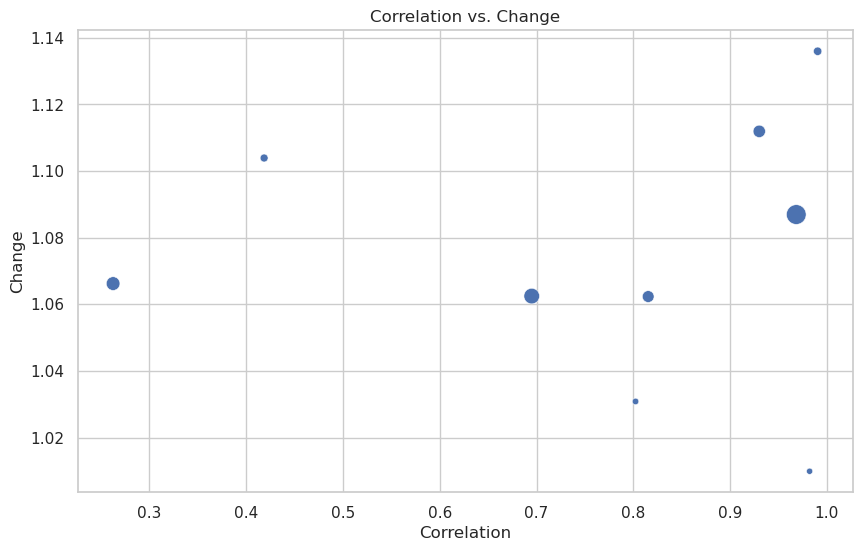

In [51]:
np.random.seed(42)

T_c = np.random.normal(loc=10, scale=3, size=10)
T_k = np.random.normal(loc=10, scale=3, size=5)
t_ck = np.random.normal(loc=10, scale=3, size=(10,5))

similarity_factor = 0.8  # Factor to control similarity (1.0 means identical)

for i in [1, 3, 8]:
    t_ck[i] = similarity_factor * t_ck[6] + (1 - similarity_factor) * np.random.normal(loc=10, scale=3, size=(5,))

theta = 3
rho = 0.4
alpha = 7
eta = 1.65

# Calculate the equilibrium using the new solver
pi_c, pi_ck, w_ck = solve_equilibrium(T_c, T_k, t_ck, theta, rho, alpha, eta)

T_c[6] = T_c[6] * 0.85
pi_shock_c, pi_shock_ck, w_shock_ck = solve_equilibrium(T_c, T_k, t_ck, theta, rho, alpha, eta)

reference_row = t_ck[6]
correlation = []
# Calculate correlation excluding row 6
for i, row in enumerate(t_ck):
    if i != 6:
        correlation.append(np.abs(np.corrcoef(reference_row, row)[0, 1]))

# Calculate change
change = pi_shock_c / pi_c

# Ensure change has the same length as correlation (excluding row 6)
change = np.delete(change, 6)

sizes = np.delete(pi_c, 6)

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Assuming correlation and change are already defined
# Plot correlation vs. change using seaborn
sns.scatterplot(x=correlation, y=change, size=sizes, sizes=(20, 200))
plt.xlabel('Correlation')
plt.ylabel('Change')
plt.title('Correlation vs. Change')
plt.legend().set_visible(False)
plt.savefig('graphs/city_shock.png')
plt.show()